# Part 2: Extensions to Basic Cellular Automata

(TODO)

## 2.1 Asynchronous Updates

Unlike the original model we developed in section 1, we now explore asynchronous updates to the model. This means that instead of updating states as a function of their relation to the previous state, we now update the cells in-place, updating one cell at a time and allowing that to affect subsequent updates. This method of updating the states of cells may better mimic a real population because a whole population doesn't have all births and deaths occur so simultaneously, and instead one death or birth may affect other processes.


## 2.2 Time To Live (TTL)

The cells in our first model in section 1 lived forever, which could be seen as somewhat unnatural, when in reality all members of a population eventually die, and without births and deaths

## 2.3 Stochasticity

Most cellular automata are perfectly deterministic models, showing the natural progression of a system whose outcome is guaranteed the moment a starting state is chosen. While this model has many interesting properties that create deterministic emergent behaviors like spaceships (a formation that's unlikely with stochasticity), it may be an oversimplification of real populations. In the real world things happen with enough variables and agents with free will that a stochastic model may be a more realistic prediction of behaviors. The argument can be made that living beings don't have free will and only that there are too many variables and factors that go in to decision making that we simply call it "free will", but we'll leave this discussion to philosophers, and state that the appearance of randomness and free will through ignorance of the multitude of factors is enough to assume stochastic processes.

To add stochasticity to our model, we can, when updating a cell, add a small probability of the cell disobeying the original rules, creating spontaneous life or dying unexpectedly. Or, relating to the asynchronous updates we discussed in section 2.1, instead of iteratively updating cells rectilinearly through the world space, we can randomly choose an element to update. 

However, we can improve this still by relating to the time to live component, by increasing the probability of being chosen the longer it has been since an update, and resetting the time to live, mimicking older cells dying and potentially being replaced with new life.

This new model is a much closer mimic of a real population than the original model, and we can examine its behavior in the exercise below.

## 2.4 Experiment

First, we copy the same imports, world initialization function, plot function, timeseries function, and update cell function from before, because these don't need to change.

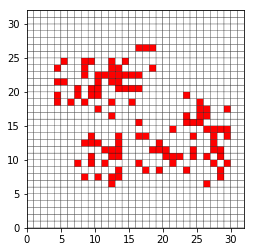

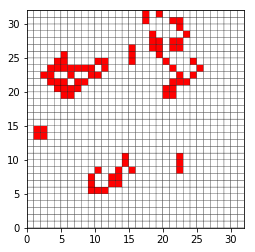

In [102]:
def init_world(n = 16, cluster_n = 4, clusters = 3, threshold = 0.25):
    world = np.zeros((n, n), dtype=int)

    for i in range(0, clusters):
        x = random.randint(0, n - cluster_n)
        y = random.randint(0, n - cluster_n)
        for world_x in range(x, x + cluster_n):
            for world_y in range(y, y + cluster_n):
                if random.uniform(0, 1) >= (1 - threshold):
                    world[world_x, world_y] = ALIVE

    return world

def update_cell(world, x, y):
    num_alive = 0
    current_state = world[x,y]

    #count neighbors
    x_range = range(max(x - 1, 0), min(x + 1, world.shape[0] - 1) + 1)
    y_range = range(max(y - 1, 0), min(y + 1, world.shape[1] - 1) + 1)

    for cell_x, cell_y in product(x_range, y_range):
        if (not (cell_x, cell_y) == (x, y) and world[cell_x, cell_y] == ALIVE):
            num_alive += 1

    if (current_state == DEAD and not num_alive == 3):
        return DEAD
    elif (current_state == ALIVE and (num_alive < 2 or num_alive > 3)):
        return DEAD
    else:
        return ALIVE

def count_alive(world):
    pass

def count_dead(world):
    pass

#brute force implementation for now, need to optimize
def timestep(world):
    rows = world.shape[0]
    cols = world.shape[1]

    new_state = np.zeros((rows, cols), dtype=int)
    for x in range(0, rows):
        for y in range(0, cols):
            new_state[x,y] = update_cell(world, x, y)

    return new_state

def plot_world(world):
    cmap = colors.ListedColormap(['white', 'red'])
    plt.pcolor(world, cmap=cmap, edgecolor="black")
    plt.axis('square')
    plt.show()

def timeseries(world, num_steps):
    simulation_steps = [world]
    for i in range(0, num_steps):
        world = timestep(world)
        simulation_steps.append(world)

    return simulation_steps

world = init_world(n = 32, cluster_n = 7, clusters = 10)
series = timeseries(world, 50)
plot_world(series[0])
plot_world(series[-1])

Then, instead of using the original timestep function to update each cell into a new world, we create an in-place call to update cell on the current world state, traversing the world-space rectilinearly.

In [103]:
#update rectilinearly
    
def timestep_async(world):
    rows = world.shape[0]
    cols = world.shape[1]
    
    new_state = world.copy()
    for x in range(0, rows):
        for y in range(0, cols):
            new_state[x,y] = update_cell(new_state, x, y)
            
    return new_state

def timeseries_async(world, num_steps):
    simulation_steps = [world]
    for i in range(0, num_steps):
        world = timestep_2(world)
        simulation_steps.append(world)

    return simulation_steps

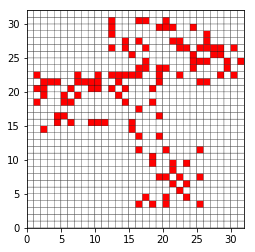

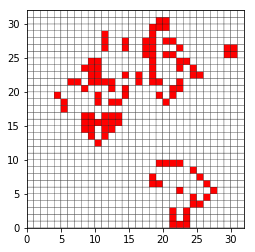

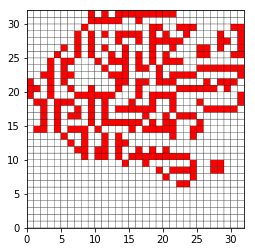

In [104]:
world = init_world(n = 32, cluster_n = 10, clusters = 5)
series = timeseries(world, 20)
series_async = timeseries_async(world, 20)
plot_world(world)
plot_world(series[-1])
plot_world(series_async[-1])

The only difference between this new timestep function and the old one is that the update_cell function is called with the current new_state version of the world instead of the old one, using all current updates in the next update. 

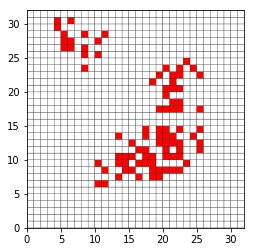

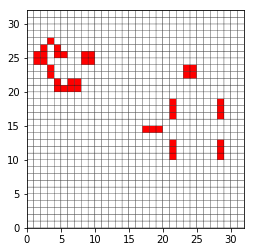

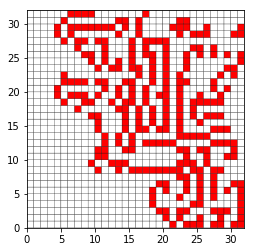

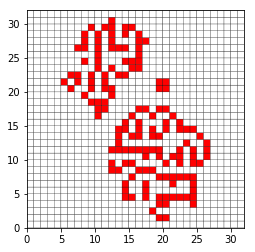

In [105]:
#update randomly
import random

def timestep_rasync(world):
    rows = world.shape[0]
    cols = world.shape[1]
    
    new_state = world.copy()
    for x in range(0, rows*cols):
        x = random.randint(0,rows-1)
        y = random.randint(0,cols-1)
        new_state[x,y] = update_cell(new_state, x, y)
            
    return new_state

def timeseries_rasync(world, num_steps):
    simulation_steps = [world]
    for i in range(0, num_steps):
        world = timestep_3(world)
        simulation_steps.append(world)

    return simulation_steps

world = init_world(n = 32, cluster_n = 8, clusters = 5)
series = timeseries(world, 50)
series_async = timeseries_async(world, 50)
series_rasync = timeseries_rasync(world, 50)
plot_world(world)
plot_world(series[-1])
plot_world(series_async[-1])
plot_world(series_rasync[-1])

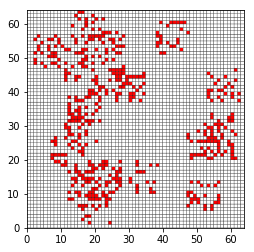

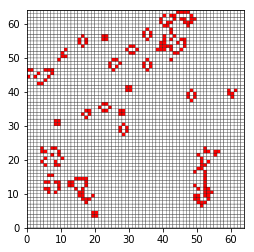

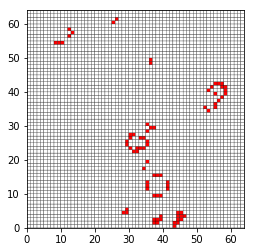

In [119]:
#time to live component
#we have to change a lot, a world now needs an equally sized array of time to live, first with normal updates
DEAD = 0
START_TTL = 6

def init_world_ttl(n = 16, cluster_n = 4, clusters = 3, threshold = 0.25):
    world = np.zeros((n, n), dtype=int)

    for i in range(0, clusters):
        x = random.randint(0, n - cluster_n)
        y = random.randint(0, n - cluster_n)
        for world_x in range(x, x + cluster_n):
            for world_y in range(y, y + cluster_n):
                if random.uniform(0, 1) >= (1 - threshold):
                    world[world_x, world_y] = START_TTL #change
    return world

def update_cell_ttl(world, x, y):
    num_alive = 0
    current_state = world[x,y]

    #count neighbors
    x_range = range(max(x - 1, 0), min(x + 1, world.shape[0] - 1) + 1)
    y_range = range(max(y - 1, 0), min(y + 1, world.shape[1] - 1) + 1)

    for cell_x, cell_y in product(x_range, y_range):
        if (not (cell_x, cell_y) == (x, y) and world[cell_x, cell_y] > DEAD):
            num_alive += 1

    if current_state == DEAD:
        if not num_alive == 3:
            return DEAD
        else:
            return START_TTL
    else:
        if num_alive != 2 and num_alive != 3:
            return DEAD
        else:
            return current_state - 1

def timestep_ttl(world):
    rows = world.shape[0]
    cols = world.shape[1]

    new_state = np.zeros((rows, cols), dtype=int)
    for x in range(0, rows):
        for y in range(0, cols):
            new_state[x,y] = update_cell_ttl(world, x, y)

    return new_state

def timeseries_ttl(world, num_steps):
    simulation_steps = [world]
    for i in range(0, num_steps):
        world = timestep_ttl(world)
        simulation_steps.append(world)

    return simulation_steps

world = init_world(n = 64, cluster_n = 10, clusters = 20)
world_ttl = init_world_ttl(n = 64, cluster_n = 10, clusters = 20)
series = timeseries(world, 50)
series_ttl = timeseries_ttl(world_ttl, 50)
plot_world(world)
plot_world(series[-1])
plot_world(series_ttl[-1])